In [18]:
%reload_ext autoreload
%autoreload 2
import pickle
from pathlib import Path
import numpy as np
from src.img_utils import get_evd, draw_evd, Visualizer
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from src.GridWorldMDP.objectworld_utils import visitation_frequency

In [19]:
def draw_all_evds(all_evds, n_query=1, file_path=None, figsize=(10, 4), dpi=120):
    '''evd_act.shape = evd_rand.shape = (# of experiments, n_trajs)'''
    title = 'Expected value difference'
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    for (exp_name, evd) in all_evds.items():
        n_trajs = evd.shape[1]
        idxs = np.arange(1*n_query, (n_trajs+1)*n_query, n_query)
        evd_mean = evd.mean(axis = 0)
        evd_std = evd.std(axis = 0)
        sns.lineplot(x=idxs, y=evd_mean, label=exp_name)
        ax.fill_between(idxs, evd_mean - evd_std, evd_mean + evd_std, alpha=0.3)
    
    ax.set_xlabel('Number of acquistions samples')
    ax.set_ylabel('Expected value difference')
    
    ax.set_title(title)
    ax.set_xticks(idxs)
    # ax.set_xticklabels(idxs)
    ax.legend()
    if file_path is not None:
        fig.savefig(str(Path(file_path).resolve()))
    plt.tight_layout()    
    plt.show()

* exp_results2: cnn, no tanh, 15개 object
* exp_results3: cnn, no tanh, 12개 object 
* exp_results4: cnn, tanh
* exp_results5: dnn, tanh, lr=0.001
* exp_results6: dnn, no tanh, weight_decay=1.2
* exp_results7: cnn, no tanh, weight_decay=2.0

In [37]:
exp_path = Path('exp_results8')

filter_keys = [ 'architecture', 'grad_clip', 'height', 'hiddens', 'learning_rate', 'n_iters', 'n_objects', 'n_query', 'n_trajs', 'weight_decay']
with open(exp_path / 'deepmaxent_active_0' / '0-train.pkl', 'rb') as f:
    h = pickle.load(f)
args = h[0]['args']
with open(exp_path / 'common_args.txt', 'w') as f:
    for k, v in args.__dict__.items():
        if k in filter_keys:
            print(k, v)
            print(f'{k}: {v}', file=f)

n_query = args.n_query

n_objects 12
height 8
n_trajs 10
learning_rate 0.002
n_iters 30
n_query 1
grad_clip 0.5
weight_decay 0.8
hiddens [8, 8]
architecture cnn


In [38]:
n_exp = 5
n_train = 8
n_test = 4
EXP_NAMES = ['deepmaxent_random', 'deepmaxent_active', 'deepmaxent_bald']
paths = [exp_path / f'{exp_name}_{i}' for exp_name in EXP_NAMES for i in range(n_exp) if (exp_path / f'{exp_name}_{i}').exists()]
paths

[WindowsPath('exp_results8/deepmaxent_random_0'),
 WindowsPath('exp_results8/deepmaxent_random_1'),
 WindowsPath('exp_results8/deepmaxent_random_2'),
 WindowsPath('exp_results8/deepmaxent_random_3'),
 WindowsPath('exp_results8/deepmaxent_random_4'),
 WindowsPath('exp_results8/deepmaxent_active_0'),
 WindowsPath('exp_results8/deepmaxent_active_1'),
 WindowsPath('exp_results8/deepmaxent_active_2'),
 WindowsPath('exp_results8/deepmaxent_active_3'),
 WindowsPath('exp_results8/deepmaxent_active_4'),
 WindowsPath('exp_results8/deepmaxent_bald_0'),
 WindowsPath('exp_results8/deepmaxent_bald_1'),
 WindowsPath('exp_results8/deepmaxent_bald_2'),
 WindowsPath('exp_results8/deepmaxent_bald_3'),
 WindowsPath('exp_results8/deepmaxent_bald_4')]

## Train

(40, 10)
(40, 10)
(40, 10)


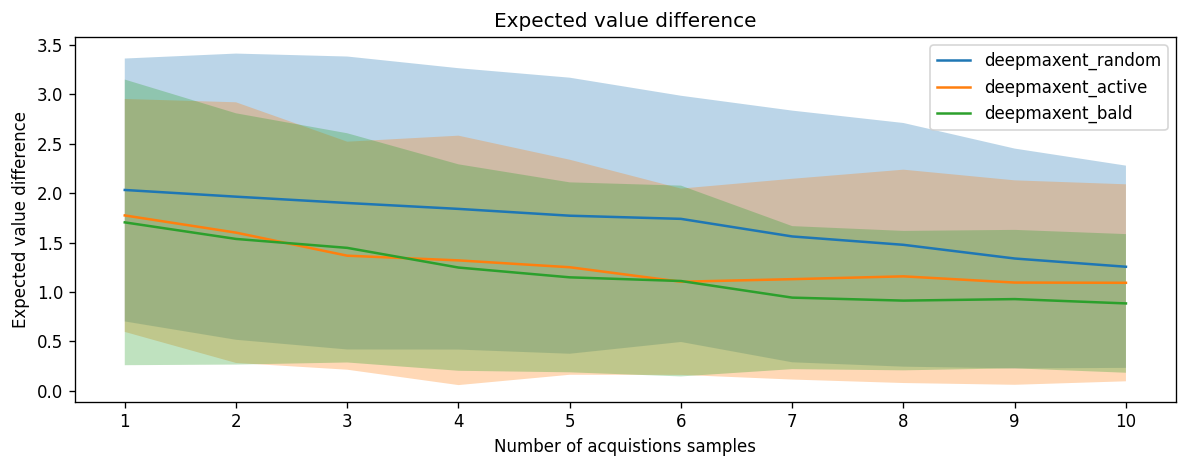

In [39]:
train_all_evds = defaultdict(list)
train_all_his = defaultdict(dict)
search_path_name = '*-train.pkl'
for exp_p in paths:
    exp, exp_name, exp_id = exp_p.name.split('_')
    exp_name = f'{exp}_{exp_name}'
    exp_id = int(exp_id)
    train_all_his[exp_name][exp_id] = []
    for i, p in enumerate(sorted(exp_p.glob(search_path_name))):
        with open(p, 'rb') as f:
            history = pickle.load(f)
        
        evds = get_evd(history)
        train_all_evds[exp_name].append(evds)
        train_all_his[exp_name][exp_id].append(history)
        
for exp_name in train_all_evds.keys():
    train_all_evds[exp_name] = np.array(train_all_evds[exp_name])
    print(train_all_evds[exp_name].shape)

draw_all_evds(train_all_evds, n_query, file_path=exp_path / 'train.png', figsize=(10, 4), dpi=120)

## Test

(20, 10)
(20, 10)
(20, 10)


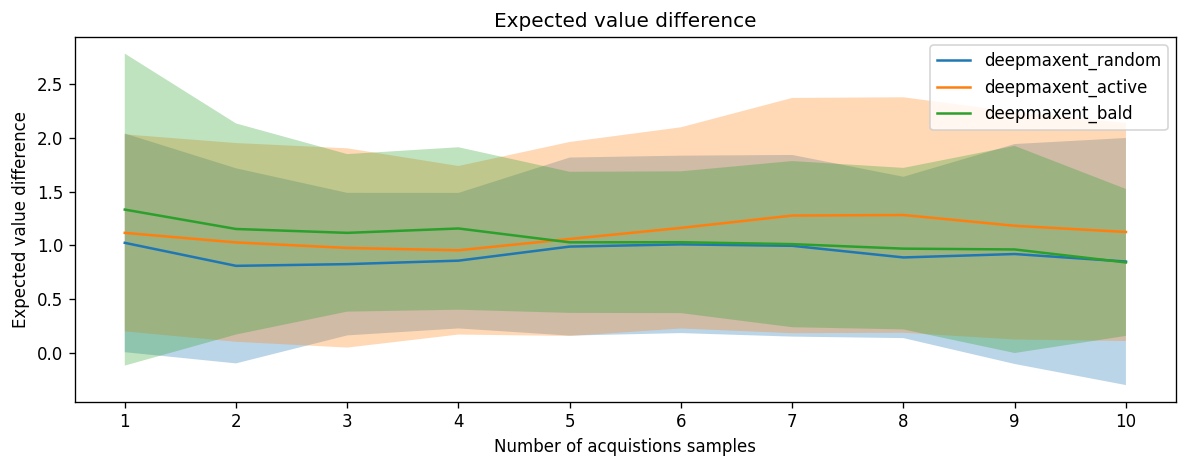

In [40]:
test_all_evds = defaultdict(list)
test_all_his = defaultdict(dict)
search_path_name = '*-test.pkl'
for exp_p in paths:
    exp, exp_name, exp_id = exp_p.name.split('_')
    exp_name = f'{exp}_{exp_name}'
    exp_id = int(exp_id)
    test_all_his[exp_name][exp_id] = []
    for i, p in enumerate(sorted(exp_p.glob(search_path_name))):
        with open(p, 'rb') as f:
            history = pickle.load(f)

        evds = get_evd(history)
        test_all_evds[exp_name].append(evds)
        test_all_his[exp_name][exp_id].append(history)
        
for exp_name in test_all_evds.keys():
    test_all_evds[exp_name] = np.array(test_all_evds[exp_name])
    print(test_all_evds[exp_name].shape)

draw_all_evds(test_all_evds, n_query, file_path=exp_path / 'test.png', figsize=(10, 4), dpi=120)

---

In [ ]:
for i in range(n_test):
    print('--------'*2 + f'{i}' + '--------'*2)
    for exp_name in EXP_NAMES:    
        visualizer = Visualizer(test_all_his[exp_name][exp_id][i], file_path=None, figsize=(18, 4), dpi=150)
        visualizer.draw_value_maps(search_idx=10, clip=False, clip_val=0.66)

In [ ]:
visualizer = Visualizer(test_all_his[exp_name][2], file_path=None, figsize=(20, 6), dpi=150)
visualizer.objectworld_reward_policy(search_idx=-1)

In [ ]:
for i in range(4):
    print('--------'*2 + f'{i}' + '--------'*2)
    for exp_name in EXP_NAMES:
        visualizer = Visualizer(test_all_his[exp_name][i], file_path=None, figsize=(20, 6), dpi=150)
        visualizer.objectworld_reward_policy(search_idx=10)

In [ ]:
for exp_name in EXP_NAMES:
    all_trajs = []
    history = test_all_his[exp_name][2]
    for i in range(1, 11):
        all_trajs.extend(history[i]['trajs'])
    freq = visitation_frequency(all_trajs, 8*8)
    # print(freq.reshape(8, 8, order='F'))
    fig, ax = plt.subplots(figsize=(10, 6), dpi=120)
    x = freq.reshape(8, 8, order='F')
    sns.heatmap(x, ax=ax, annot=True, fmt='d')#, cmap='coolwarm')
    # maskout zero values in the heatmap
    mask = x != 0
    for text, show_annot in zip(ax.texts, mask.ravel()):
        text.set_visible(show_annot)
    ax.set_title(f'Visitation Frequency - {exp_name.split("_")[1].capitalize()}')

# Seperate

In [14]:
with open(exp_path / 'deepmaxent_active-exp_results.pkl', 'rb') as file:
    res_active = pickle.load(file)

with open(exp_path / 'deepmaxent_random-exp_results.pkl', 'rb') as file:
    res_random = pickle.load(file)

with open(exp_path / 'deepmaxent_bald-exp_results.pkl', 'rb') as file:
    res_bald = pickle.load(file)

In [15]:
exp_id = 2

train_evds = defaultdict(list)
test_evds = defaultdict(list)
for exp_name, data in zip(EXP_NAMES, [res_random, res_active]):#, res_bald]):
    for i, exp in enumerate(data):
        train_evds[exp_name].append(exp['train_evds'])
        test_evds[exp_name].append(exp['test_evds'])
    train_evds[exp_name] = np.array(train_evds[exp_name])[exp_id]
    test_evds[exp_name] = np.array(test_evds[exp_name])[exp_id]

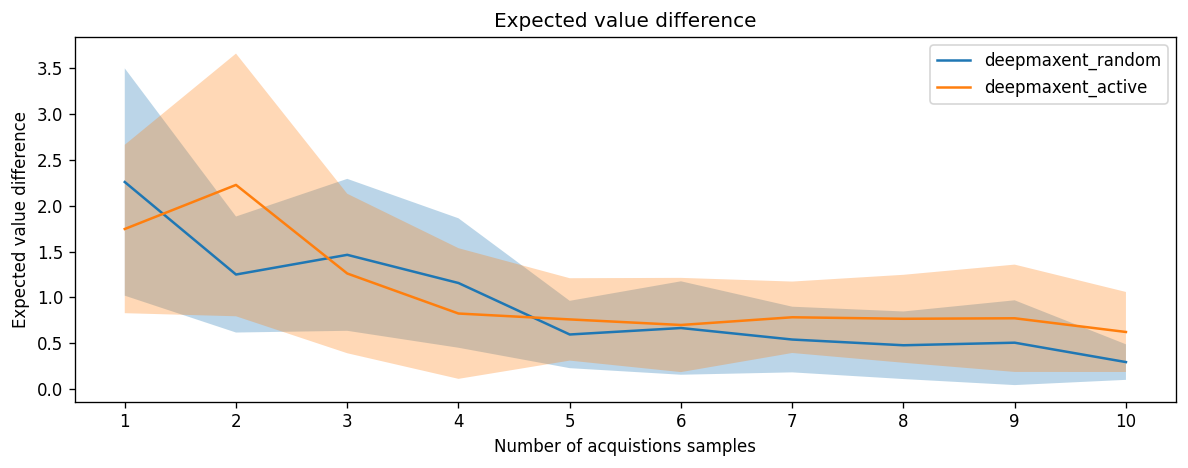

In [16]:
draw_all_evds(train_evds, figsize=(10, 4), dpi=120)

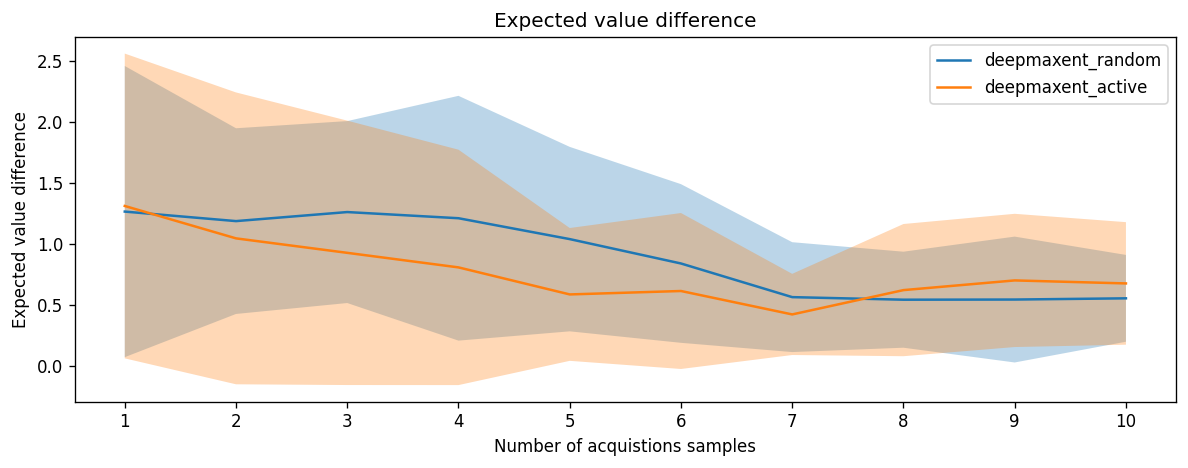

In [17]:
draw_all_evds(test_evds, figsize=(10, 4), dpi=120)